In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import glob
import datetime
import numpy as np
import datetime
from pathlib import Path
import os

In [3]:
# due working at home and work windows and linux
import platform
import os

if platform.system() == 'Windows' and platform.release() == '10':
    os.chdir(r'L:\andre\PycharmProjects\geonumerics\ipython_notebooks\Stocks\RForex')
elif platform.system() == 'Windows' and platform.release() == '7':
    os.chdir(r'C:\Data\VBShared\ipython_notebooks\Stocks\RForex')
elif platform.system() == 'Linux' and platform.node() == 'riossm31012722':
    os.chdir('/media/windows/Data/VBShared/ipython_notebooks/Stocks/RForex')
elif platform.system() == 'Linux' and platform.node() == 'andre-PredatorG3571':
    os.chdir('/home/andre/PycharmProjects/geonumerics/ipython_notebooks/Stocks/RForex')

In [4]:
import RF_Forex as rf_forex
import RF_Prediction as rf_predictor
import Meta5_Ibov_Load as meta5_ibov_load

In [5]:
import importlib
importlib.reload(rf_predictor)
importlib.reload(rf_forex)
importlib.reload(meta5_ibov_load)

<module 'Meta5_Ibov_Load' from '/home/andre/PycharmProjects/geonumerics/ipython_notebooks/Stocks/RForex/Meta5_Ibov_Load.py'>

In [6]:
if platform.system() == 'Windows' and platform.release() == '10':
    meta5_ibov_load.Set_Data_Path(r'L:\andre\PycharmProjects\geonumerics\ipython_notebooks\Stocks\data',
                                 r'L:\andre\PycharmProjects\geonumerics\ipython_notebooks\Stocks\2016_stocks\2016_2018_M1')
elif platform.system() == 'Windows' and platform.release() == '7':
    meta5_ibov_load.Set_Data_Path(r'C:\Data\VBShared\ipython_notebooks\Stocks\data',
                                 r'C:\Data\VBShared\ipython_notebooks\Stocks\2016_stocks\2016_2018_M1')
elif platform.system() == 'Linux' and platform.node() == 'riossm31012722':
    meta5_ibov_load.Set_Data_Path(r'/media/windows/Data/VBShared/ipython_notebooks/Stocks/data',
                                r'/media/windows/Data/VBShared/ipython_notebooks/Stocks/2016_stocks/2016_2018_M1')
elif platform.system() == 'Linux' and platform.node() == 'andre-PredatorG3571':
    meta5_ibov_load.Set_Data_Path(r'/home/andre/PycharmProjects/geonumerics/ipython_notebooks/Stocks/data',
                            r'/home/andre/PycharmProjects/geonumerics/ipython_notebooks/Stocks/2016_stocks/2016_2018_M1')
    #os.chdir('/media/windows/Data/VBShared/ipython_notebooks/Stocks/2016_stocks\2016_2018_M1'')

masterdf = meta5_ibov_load.Load_Meta5_Data()

master data loaded size (minutes) 228751
Symbols lodaded:
0    BBDC4
1     DOL$
2    VALE3
3    BBAS3
4    PETR4
5    ABEV3
6    BVMF3
7    ITUB4
dtype: object
data already loaded


In [7]:
targetquote='VALE3'

In [8]:
index_file = targetquote+'_full_sIndex_data.pickle'
xtrain_file = targetquote+'_full_Xtrain_data.pickle'
ytrain_file = targetquote+'_full_ytrain_data.pickle'

In [9]:
index_file = os.path.join(meta5_ibov_load.path_data_bundle, index_file)
xtrain_file = os.path.join(meta5_ibov_load.path_data_bundle, xtrain_file)
ytrain_file = os.path.join(meta5_ibov_load.path_data_bundle, ytrain_file)

In [10]:
sIndex = pd.read_pickle(index_file)
Xtrain = pd.read_pickle(xtrain_file)
ytrain = pd.read_pickle(ytrain_file)

In [11]:
# change here if you wish OPTIONS
# shift=60
nforecast=60
nvalidation=nforecast # to validate the model prior prediction
ntraining = 8*60 # 8 hours before for training
nwindow = nvalidation+nforecast+ntraining 
estimators = 800

### just 22 days of data slice it

In [12]:
starti = 0
endi = 2000

In [13]:
Xtrain = Xtrain.iloc[starti:endi]
ytrain = ytrain.iloc[starti:endi]
sIndex = sIndex.iloc[starti:endi]

## Linux Python Paralel Processing

In [17]:
""""Executor of prediction"""
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import RF_Prediction as rf_predictor
import RF_Forex as rf_forex
import scipy
import sys


def Slide_Predictions_Up_Down(X, y, index, verbose=False):
    """
    Backtesting:
    Make predictions of up and downs with a sliding window.    
    """
    size = len(X)
    # number of possible predictions with data size : size
    # because forecast are allways array of forecasts
    # defined by the shift made
    nshifts = size-(ntraining+nvalidation+nforecast)     
    
    if nshifts <= 0:
        print('somethings is wrong, array of data too small')
        print('minimum size is training+validation+forecast for 1 prediction')
        return
    
    if verbose:
        print('maximum number of predictions is: ', nshifts)    
    
    # sliding window with step of one sample shift   
    prediction_book = pd.DataFrame(index=np.arange(nshifts), columns=['tindex', 'buy', 'score', 'prob'])
    
    for i in rf_predictor.progressbar(range(nshifts)):  
        
        index_ = index[i:i+nwindow].copy()        
        # training samples are the first ones
        X_t = X[i:i+ntraining]
        y_t = y[i:i+ntraining]        

        # control samples for scoring (validation of the model)
        # SCORE using the nforecast samples just after the window       
        X_s = X[i+ntraining:i+ntraining+nvalidation]
        y_s = y[i+ntraining:i+ntraining+nvalidation]

        # predict on the last nforecast samples
        X_p = X[i+ntraining+nvalidation:i+ntraining+nvalidation+nforecast]

        # using all core -1 : 8 cores
        clfmodel = ExtraTreesClassifier(n_estimators=estimators, min_samples_split=2,
                                        n_jobs=1, bootstrap=True, max_depth=None) 
        clfmodel.fit(X_t, y_t)    

        # test accurary of the model if higher than 90% we can predict
        score = clfmodel.score(X_s, y_s)            
        
        if score < 0.9: # we cannot predict unless the model is 90% accurate
            del clfmodel
            continue    

        proba = clfmodel.predict_proba(X_p)        
        prediction = clfmodel.predict(X_p)  
        down = abs(prediction.sum()-len(prediction))/len(prediction)
        up = abs(1-down)

        if up > 0.9 or down > 0.9: # only if certain by 90% that will go up or down
            # where will it be bought in time
            # allways +5 minutes after prediction
            tindex = index_.iloc[-nforecast+5]
            buy = up > down
            if buy: # buy
                buy = 1
            else: # sell
                buy = -1
            prediction_book.iloc[i] = [tindex, buy, score, np.max(np.prod(proba, axis=0)**(1./60.))]
            print(prediction_book.iloc[i])
            
        del clfmodel
        
    return prediction_book

# splitting data to guarantee overlapping multiprocessing
# split data in a batch with limits [start:end]
def paralel_Slide_Predictions_Up_Down(Xtrain, ytrain, sIndex, start, end, targetquote):    
    X = Xtrain[start:end]
    y = ytrain[start:end]
    index = sIndex[start:end]        
    prediction_book = Slide_Predictions_Up_Down(X.copy(), y.copy(), index.copy())    
    # save recommended orders from starti to endi
    prediction_book.dropna(inplace=True) # due preallocated size there are nan samples
    return prediction_book
    
def paralel_batch_slices(nprocesses, datasize, nwindow):
    """
    create batch slice indexes for paralel processing
    should write test function for this
    altough it is perfectly working
    """
    batch_size = int(np.floor((datasize-nwindow)/nprocesses))
    nmiss = (datasize-nwindow-batch_size*nprocesses) # samples to complete the non integer division
    # last batch will have more sample to complete the non integer division
    slices = np.array([i*batch_size for i in range(nprocesses)])
    # each batch must have the previous sample size of training + forecast window
    istarts = slices
    iends = slices[1:] + nwindow
    iends = np.append(iends, datasize)
    # first and last batch have different size of samples
    print('batch starts ', istarts)
    print('batch ends ', iends)
    print('batch sizes ', iends-istarts) 
    batches = zip(istarts, iends)
    return batches

In [18]:
%%time

from joblib import Parallel, delayed
import multiprocessing

nprocesses = 8
num_cores = nprocesses
batches = paralel_batch_slices(nprocesses, len(Xtrain), nwindow)

results = Parallel(n_jobs=num_cores)(
    delayed(paralel_Slide_Predictions_Up_Down)(Xtrain, ytrain, sIndex, start, end, targetquote)
    for start, end in batches)

batch starts  [   0  175  350  525  700  875 1050 1225]
batch ends  [ 775  950 1125 1300 1475 1650 1825 2000]
batch sizes  [775 775 775 775 775 775 775 775]
tindex    2016-01-06 17:50:00....................................................] 1/175
buy                        -1
score                       1
prob                 0.952851
Name: 0, dtype: object
tindex    2016-01-06 17:51:00....................................................] 2/175
buy                        -1
score                       1
prob                 0.953385
Name: 1, dtype: object
tindex    2016-01-06 17:52:00....................................................] 3/175
buy                        -1
score                       1
prob                 0.962469
Name: 2, dtype: object
tindex    2016-01-06 17:53:00....................................................] 4/175
buy                        -1
score                       1
prob                 0.963636
Name: 3, dtype: object
tindex    2016-01-06 17:54:00......

tindex    2016-01-08 14:29:00....................................................] 27/175
buy                        -1
score                       1
prob                 0.690322
Name: 23, dtype: object
tindex    2016-01-06 15:17:00....................................................] 24/175
buy                        -1
score                       1
prob                 0.623989
Name: 22, dtype: object
tindex    2016-01-07 10:27:00....................................................] 25/175
buy                        -1
score                       1
prob                 0.955531
Name: 23, dtype: object
tindex    2016-01-08 14:30:00....................................................] 27/175
buy                        -1
score                       1
prob                 0.700912
Name: 24, dtype: object[###########.....................................................................] 26/175
tindex    2016-01-06 15:18:00....................................................] 25/175
buy  

Name: 36, dtype: object
tindex    2016-01-08 14:42:00....................................................] 42/175
buy                        -1
score                       1
prob                 0.712081
Name: 36, dtype: object
tindex    2016-01-06 15:30:00....................................................] 39/175
buy                        -1
score                       1
prob                 0.641025
Name: 35, dtype: object
tindex    2016-01-07 10:42:00....................................................] 43/175
buy                        -1
score                       1
prob                 0.920929
Name: 37, dtype: object
tindex    2016-01-08 14:43:00....................................................] 38/175
buy                        -1
score                       1
prob                 0.719022
Name: 37, dtype: object
tindex    2016-01-06 15:31:00....................................................] 40/175
buy                        -1
score                       1
prob      

KeyboardInterrupt: 

In [55]:
pd = results[0]
for result in results[1:]:
    pd = pd.append(result)
pd.reset_index(drop=True, inplace=True)

### just quality control split worked for multiprocessing

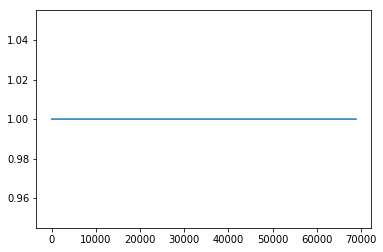

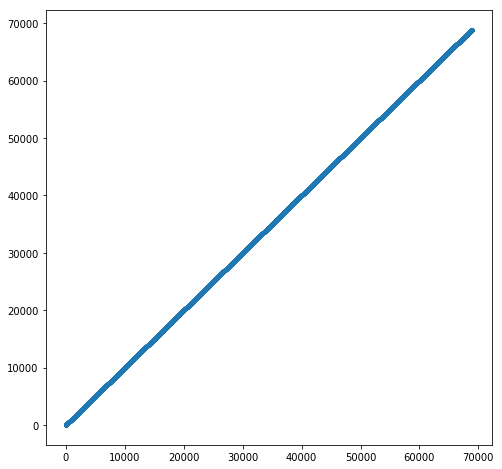

In [58]:
ix = pd.loc[ pd.tindex.sort_values().index ].index.values
plt.plot(np.diff(ix))
plt.figure(figsize=(8,8))
plt.plot(pd.loc[ pd.tindex.sort_values().index ].index, '.')

In [59]:
cd /media/windows/Data/VBShared/ipython_notebooks/Stocks/data

[Errno 2] No such file or directory: '/media/windows/Data/VBShared/ipython_notebooks/Stocks/data'
/home/andre/PycharmProjects/geonumerics/ipython_notebooks/Stocks


In [60]:
pd.to_pickle(targetquote+'_0_'+str(endi)+'_prob_prediction.pickle')

In [23]:
pd.to_pickle(targetquote+'_0_'+str(endi)+'_prediction.pickle')

In [ ]:
scores = cross_val_score(clf, X_testFold, y_testFold, verbose=True)
scores.mean()

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
clfmodel = ExtraTreesClassifier(n_estimators=estimators, n_jobs=-1, bootstrap=True, verbose=True, max_depth=None, min_samples_split=2) 
scores = cross_val_score(clfmodel, X_trainFolds, y_trainFolds)
scores 

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elap

array([ 0.31055901,  0.88125   ,  0.81761006])

In [59]:
clfmodel = ExtraTreesClassifier(n_estimators=estimators, n_jobs=-1, bootstrap=True, verbose=True) 

scores = cross_val_score(clfmodel, X_trainFolds, y_trainFolds)
scores.mean()    

[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elap

0.67291666666666661

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [56]:
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X_trainFolds, y_trainFolds)
scores.mean()         

0.64166666666666672

In [57]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X_trainFolds, y_trainFolds)
scores.mean()

0.71041666666666659

In [58]:
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X_trainFolds, y_trainFolds)
scores.mean()

0.67083333333333339

In [28]:
clfmodel.n_features_

363

In [ ]:
clfmodel.fit(X_trainFolds, y_trainFolds)

In [39]:
import pandas as pd
import numpy as np

In [46]:
features_relevance = pd.DataFrame(np.array([X_trainFolds.columns.values, clfmodel.feature_importances_]).T,
                                 columns=['features', 'relavance'])

In [51]:
features_relevance.set_index('features', drop=True, inplace=True)

In [53]:
features_relevance.relavance.sort_values().head()

features
dema_3VALE3_C    0.00103713
dema_3ITUB4_H    0.00120644
dema_2ITUB4_C    0.00123619
rsi_3ITUB4_C     0.00124542
dema_5BVMF3_C    0.00128143
Name: relavance, dtype: object

In [ ]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_trainFolds)  
X_train = scaler.transform(X_trainFolds)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [54]:
from sklearn.neural_network import MLPClassifier
X = [[0., 0.], [1., 1.]]
y = [0, 1]
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_trainFolds, X_testFold)                         


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [65]:
scores = cross_val_score(clf, X_testFold, y_testFold, verbose=True)
scores.mean()

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


0.4595238095238095